# Finding Grammar in Neural language models

We will investigate a language model trained on the penn treebank dataset, using the code provided at https://github.com/pytorch/examples/tree/master/word_language_model. The model consists of an encoder with 2 hidden LSTM layers with 1500 units, and a linear output layer to which a softmax function is applied. The word embeddings have dimensionality 1500. The model is trained for 40 epochs with a dropout factor of 0.65 and has a test perplexity of 72.30 on the test set. If you are interested in more detail in the model, we advise you to look at the repository containing the code.

In this notebook, we will walk you through an example of how you can compute the probabilties of the next word in a sentence. You can then use this to start your replication of Linzen et al.

In [133]:
# do required imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2834)
import matplotlib.ticker as mtick

If you downloaded and extracted the zipfile, you should have all data required: the model, and the pickled dictionary mapping words to indices.

Lets start by loading the model. Because the model was trained on a GPU, we need to specifically say that it should be loaded on the CPU when we load it:

In [40]:
lm = torch.load('model.pt', map_location=lambda storage, loc: storage)

In [41]:
# print a summary of the architecture of your model
print(lm)

RNNModel (
  (drop): Dropout (p = 0.65)
  (encoder): Embedding(10000, 1500)
  (rnn): LSTM(1500, 1500, num_layers=2, dropout=0.65)
  (decoder): Linear (1500 -> 10000)
)


### Evaluating a single sentence

We will give an example of how you can get the probabilties for the next word in a single sentence. We will uset he example sentence:<br>

"This is a sentence with seven"

And print the probabilities of completing this sentence with either 'words', 'characters', 'thursday', 'days' or 'walk'. As the model itself does not include the mapping from words to indices, we will need to do this as a preprocessing step. The dictionary that maps words to indices is stored in a pickled file called 'dict'.

In [42]:
# Load dictionary word --> id 
dictionary = pickle.load(open('dict', 'rb'))

# set the maximum sequence length
max_seq_len = 50

# function to transform sentence into word id's and put them in a pytorch Variable
# NB Assumes the sentence is already tokenised!
def tokenise(sentence, dictionary):
    words = sentence.split(' ')
    l = len(words)
    assert l <= max_seq_len, "sentence too long"
    token = 0
    ids = torch.LongTensor(l)

    for word in words:
        try:
            ids[token] = dictionary.word2idx[word]
        except KeyError:
            print( word)
            raw_input()
            ids[token] = dictionary.word2idx['<unk>']
        token += 1
    return ids

We now define a function that can be used to evaluate a single sentence and print the probabilities of finishing this sentence with a word from a list of input words.

In [43]:
# load pytorch softmax function
softmax = nn.Softmax()

def evaluate(model, dictionary, sentence, check_words):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    
    # number of tokens (= output size)
    ntokens = len(dictionary)
    hidden = model.init_hidden(1)
    
    # tokenise the sentence, put in torch Variable
    test_data = tokenise(sentence, dictionary)
    input_data = Variable(test_data, volatile=True)

    # run the model, compute probabilities by applying softmax
    output, hidden = model(input_data, hidden)
    output_flat = output.view(-1, ntokens)
    logits = output[-1, :]
    sm = softmax(logits).view(ntokens)
    
    # get probabilities of certain words by looking up their
    # indices and print them
    def get_prob(word):
        return sm[dictionary.word2idx[word]].data[0]

    #print (sentence, '\n')
    #print ('\n'.join(
    #        ['%s: %f' % (word, get_prob(word)) for word in check_words]
    #        ) )

    return {word : get_prob(word) for word in check_words}

In [44]:
# test sentence and words to check
test_sentence = 'this is a sentence with seven'
check_words = ['words', 'characters', 'thursday', 'days', 'walk']

In [45]:
evaluate(lm, dictionary, test_sentence, check_words)

{'characters': 7.000279583735391e-05,
 'days': 0.002636461518704891,
 'thursday': 1.165580556516943e-06,
 'walk': 5.386583779909415e-06,
 'words': 0.0009886504849418998}

# Now try it yourself

You can now start with your replication of Linzen's paper, for which the first step is to try different inputs with varying distances etc. to get a feeling for what the model is doing and to familiarise yourself with using it.

In [46]:
test_sentence = "the toy on the tables"
check_words = ["is", "are"]
evaluate(lm, dictionary, test_sentence, check_words)

{'are': 0.031047170981764793, 'is': 0.00332761462777853}

In [136]:
# Compose sentence prefixes with frequent words.
# The sentence prefixes are intended to test intervening nouns.


NN = ['company', 'year', 'market', 'share', 'stock', 'system', 'president', 'business', 
      'quarter', 'government', 'time', 'week', 'price', 'group', 'interest',
      'industry', 'unit','month', 'rate', 'investment', 'state', 'producer', 'income', 
      'program', 'bank', 'part', 'plan', 'sale', 'issue', 'tax', 'way', 'loss', 'executive', 'day', 'bid', 'data', 'line','hour', 'plant', 'concern']

NNS = ['companies', 'years', 'markets', 'shares', 'stocks', 'systems', 'presidents', 
       'businesses', 'quarters', 'governments', 'times', 'weeks', 'prices', 'groups', 'interests', 'industries', 
       'units', 'months', 'rates', 'investments', 'states', 'producers', 'incomes', 'programs', 'banks', 'parts', 'plans', 
      'sales', 'issues', 'taxes', 'ways', 'losses', 'executives', 'days', 'bids', 'data', 'lines', 'hours', 'plants', 'concerns',]

VBP = ['are', 'have', 'do', 'say', 'think', 'want', 'expect', 'include', 'ask', 
       'make', 'need', 'know', 'see', 'get', 'seem', 'remain', 'continue', 'show', 'buy', 
       'feel', 'go', 'sell', 'take', 'use', 'plan', 'look', 'tend', 'hope', 'argue', 'give',
       'pay', 'appear', 'suggest', 'fear', 'find', 'come', 'offer', 'contend', 'agree', 'provide']

VBZ = ['is', 'has', 'does', 'says', 'thinks', 'wants', 'expects', 'includes', 'asks', 'makes',
      'needs', 'knows', 'sees', 'gets', 'seems', 'remains', 'continues', 'shows', 'buys', 'feels', 'goes', 'sells',
      'takes', 'uses', 'plans', 'looks', 'tends', 'hopes', 'argues', 'gives', 'pays', 'appears', 'suggests', 'fears',
      'finds', 'comes', 'offers', 'contends', 'agrees', 'provides']

attractor_helpers = ['in the', 'by the', 'close to the', 'of the', 'at the', 'ant not the', 'without']

words = {
    "NN1" : "product",
    "NNS1" : "products",
    "NN2" : "company",
    "NNS2" : "companies",
    "VBP1" : "looks",
    "VBZ1" : "look",
    "VBP2" : "produces",
    "VBZ2" : "produce",
}
sentences = [
    (f"the {words['NN1']} of the {words['NN2']}", [words['VBP1'], words['VBZ1']], words['VBP1']),
    (f"the {words['NNS1']} of the {words['NN2']}", [words['VBP1'], words['VBZ1']], words['VBZ1']),
    (f"the {words['NN1']} of the {words['NNS2']}", [words['VBP1'], words['VBZ1']], words['VBP1']),
    (f"the {words['NNS1']} of the {words['NNS2']}", [words['VBP1'], words['VBZ1']], words['VBZ1']),

    (f"the {words['NN1']} that the {words['NN2']}", [words['VBP2'], words['VBZ2']], words['VBP2']),
    (f"the {words['NNS1']} that the {words['NN2']}", [words['VBP2'], words['VBZ2']], words['VBP2']),
    (f"the {words['NN1']} that the {words['NNS2']}", [words['VBP2'], words['VBZ2']], words['VBZ2']),
    (f"the {words['NNS1']} that the {words['NNS2']}", [words['VBP2'], words['VBZ2']], words['VBZ2']),

    (f"the {words['NN1']} that the {words['NN2']} {words['VBP2']}", [words['VBP1'], words['VBZ1']], words['VBP1']),
    (f"the {words['NNS1']} that the {words['NN2']} {words['VBP2']}", [words['VBP1'], words['VBZ1']], words['VBZ1']),
    (f"the {words['NN1']} that the {words['NNS2']} {words['VBZ2']}", [words['VBP1'], words['VBZ1']], words['VBP1']),
    (f"the {words['NNS1']} that the {words['NNS2']} {words['VBZ2']}", [words['VBP1'], words['VBZ1']], words['VBZ1'])
]

print("(sentence, options, correct-option):")
sentences

(sentence, options, correct-option):


[('the product of the company', ['looks', 'look'], 'looks'),
 ('the products of the company', ['looks', 'look'], 'look'),
 ('the product of the companies', ['looks', 'look'], 'looks'),
 ('the products of the companies', ['looks', 'look'], 'look'),
 ('the product that the company', ['produces', 'produce'], 'produces'),
 ('the products that the company', ['produces', 'produce'], 'produces'),
 ('the product that the companies', ['produces', 'produce'], 'produce'),
 ('the products that the companies', ['produces', 'produce'], 'produce'),
 ('the product that the company produces', ['looks', 'look'], 'looks'),
 ('the products that the company produces', ['looks', 'look'], 'look'),
 ('the product that the companies produce', ['looks', 'look'], 'looks'),
 ('the products that the companies produce', ['looks', 'look'], 'look')]

In [229]:
def calculate_error_rate(sentences):
    result = [1 if is_correct_prediction(s[0], s[1], s[2]) else 0 for s in sentences]
    #print(result)
    return 1- sum(result)/len(result)
    

def is_correct_prediction(sentence, check_words, correct_word):
    predictions = evaluate(lm, dictionary, sentence, check_words)
    predicted_word = max(predictions, key=predictions.get)
    return predicted_word == correct_word
    
is_correct_prediction(sentences[0][0], sentences[0][1], sentences[0][2])
calculate_error_rate(sentences)

0.33333333333333337

In [372]:
# Compose sentence prefixes with frequent words with one and without attractors

def gen_no_attractors(num_sentences, num_words, NN, NNS, VBP, VBZ):
    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices = []
    for i in range(num_sentences):
        while True:
            x,y = np.random.randint(num_words, size=2)
            if (x,y) not in indices:
                indices.append((x,y))
                break
        sentences_si.append((f"the {NN[x]}", [VBP[y], VBZ[y]], VBZ[y],))
        sentences_pl.append((f"the {NNS[x]}", [VBP[y], VBZ[y]], VBP[y],))
    return sentences_si, sentences_pl

def gen_one_attractor(num_sentences, num_words,same,NN, NNS, VBP, VBZ):
    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    sentences_si = []
    sentences_pl =[]
    indices = []
    for i in range(num_sentences):
        while True:
            x,y,z = np.random.randint(num_words, size=3)
            if (x,y,z) not in indices:
                indices.append((x,y,z))
                break
        if(same):
            sentences_si.append((f"the {NN[x]} of the {NN[z]}", [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((f"the {NNS[x]} of the {NNS[z]}", [VBP[y], VBZ[y]], VBP[y],))
        else:
            sentences_si.append((f"the {NN[x]} of the {NNS[z]}", [VBP[y], VBZ[y]], VBZ[y],))
            sentences_pl.append((f"the {NNS[x]} of the {NN[z]}", [VBP[y], VBZ[y]], VBP[y],))
            
    return sentences_si, sentences_pl

num_sentences = 1000
num_words = len(NN)

no_attractors_si, no_attractors_pl = gen_no_attractors(num_sentences, num_words, NN, NNS, VBP, VBZ)
one_attractor_si_same, one_attractor_pl_same = gen_one_attractor(num_sentences, num_words,True, NN, NNS, VBP, VBZ)
one_attractor_si_diff, one_attractor_pl_diff = gen_one_attractor(num_sentences, num_words,False, NN, NNS, VBP, VBZ)


In [373]:
# caluclate error for 2b
err_no_attractors_si = calculate_error_rate(no_attractors_si)
err_no_attractors_pl = calculate_error_rate(no_attractors_pl)
err_one_attractor_si_same =  calculate_error_rate(one_attractor_si_same)
err_one_attractor_pl_same = calculate_error_rate(one_attractor_pl_same)
err_one_attractor_si_diff = calculate_error_rate(one_attractor_si_diff)
err_one_attractor_pl_diff = calculate_error_rate(one_attractor_pl_diff)

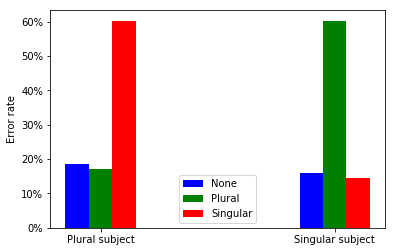

In [374]:
#reproduce plot from the paper 2b
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [err_no_attractors_pl, err_no_attractors_si]
rects1 = ax.bar(ind, yvals, width, color='b')
zvals = [err_one_attractor_pl_same, err_one_attractor_si_diff]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [err_one_attractor_pl_diff, err_one_attractor_si_same ]
rects3 = ax.bar(ind+width*2, kvals, width, color='r')

ax.set_ylabel('Error rate')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Plural subject', 'Singular subject') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('None', 'Plural', 'Singular') )
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()
fig.savefig('2b.pdf')

In [375]:
print("Error plural subject: (None, Plural, Singular)")
print((err_no_attractors_pl, err_one_attractor_pl_same,err_one_attractor_pl_diff))
print("Erro singular subject: (None, Plural, Singular)")
print((err_no_attractors_si,err_one_attractor_si_diff,err_one_attractor_si_same))

Error plural subject: (None, Plural, Singular)
(0.18600000000000005, 0.17200000000000004, 0.602)
Erro singular subject: (None, Plural, Singular)
(0.16100000000000003, 0.603, 0.14500000000000002)


In [376]:
# Compose sentence prefixes with frequent words with 0-4 attractors 
def gen_num_attractors(num_sentences, num_words, num_attractors, NN, NNS, VBP, VBZ, helper):
    assert(num_attractors >= 0)
    assert(len(NN) == len(NNS) == len(VBP) == len(VBZ))
    x,y = np.random.randint(2, size=2)
    sentences = []
    store_indices = []
    for i in range(num_sentences):
        while True:
            indices = np.random.randint(num_words, size=2+num_attractors+1)
            if tuple(indices) not in store_indices:
                store_indices.append(tuple(indices))
                break
#  all combinations of homogenous interventions gives strange results see: 2c_mixed.pdf
#
#         if(x == 0):
#             sent = f"the {NN[indices[0]]}"
#         else:
#             sent = f"the {NNS[indices[0]]}"
#         for j in range(1,num_attractors+1):
#             index = np.random.randint(len(helper), size=1)[0]
#             if(y == 0):
#                 sent += f" {helper[index]} {NNS[indices[j]]}"
#             else:
#                 sent += f" {helper[index]} {NN[indices[j]]}"
#         if(x == 0):
#             sentences.append((sent, [VBP[indices[-1]], VBZ[indices[-1]]], VBZ[indices[-1]]))
#         else:
#             sentences.append((sent, [VBP[indices[-1]], VBZ[indices[-1]]], VBP[indices[-1]]))

# just homogenous interventions where the attractor has a different plurality than the subject
        if(x == 0):
            sent = f"the {NN[indices[0]]}"
            for j in range(1,num_attractors+1):
                index = np.random.randint(len(helper), size=1)[0]
                sent += f" {helper[index]} {NNS[indices[j]]}"
            sentences.append((sent, [VBP[indices[-1]], VBZ[indices[-1]]], VBZ[indices[-1]]))
        else:
            sent = f"the {NNS[indices[0]]}"
            for j in range(1,num_attractors+1):
                index = np.random.randint(len(helper), size=1)[0]
                sent += f" {helper[index]} {NN[indices[j]]}"
            sentences.append((sent, [VBP[indices[-1]], VBZ[indices[-1]]], VBP[indices[-1]]))
    return sentences

no_attr = gen_num_attractors(num_sentences, num_words, 0, NN, NNS, VBP, VBZ, attractor_helpers)
one_attr = gen_num_attractors(num_sentences, num_words, 1, NN, NNS, VBP, VBZ, attractor_helpers)
two_attr = gen_num_attractors(num_sentences, num_words, 2, NN, NNS, VBP, VBZ, attractor_helpers)
three_attr = gen_num_attractors(num_sentences, num_words, 3, NN, NNS, VBP, VBZ, attractor_helpers)
four_attr = gen_num_attractors(num_sentences, num_words, 4, NN, NNS, VBP, VBZ, attractor_helpers)

In [377]:
# caluclate error for 2c for singular and plural subjects
err_no_attr = calculate_error_rate(no_attr)
err_one_attr = calculate_error_rate(one_attr)
err_two_attr = calculate_error_rate(two_attr)
err_three_attr = calculate_error_rate(three_attr)
err_four_attr = calculate_error_rate(four_attr)

In [378]:
print("Error number of attractors: (0, 1, 2, 3, 4) ")
print((err_no_attr, err_one_attr, err_two_attr, err_three_attr, err_four_attr))

Error number of attractors: (0, 1, 2, 3, 4) 
(0.15500000000000003, 0.729, 0.8109999999999999, 0.6579999999999999, 0.84)


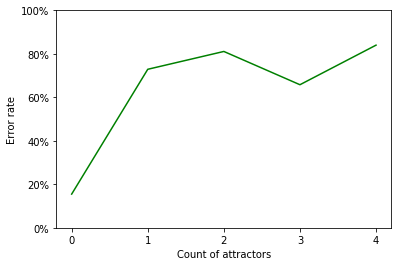

In [379]:
# plot error for 2c for singular and plural subjects
err = [err_no_attr, err_one_attr,err_two_attr,err_three_attr,err_four_attr]

x = np.arange(0,5) 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Error rate')
ax1.set_xlabel('Count of attractors')
ax1.plot(x, err, color='g')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax1.set_ylim([0,1])
ax1.legend(loc=2)
plt.show()
fig.savefig('2c.pdf')

In [380]:
print(no_attr[0:4])
print()
print(one_attr[0:4])
print()
print(two_attr[0:4])
print()
print(three_attr[0:4])
print()
print(four_attr[0:4])

[('the system', ['make', 'makes'], 'makes'), ('the sale', ['show', 'shows'], 'shows'), ('the producer', ['show', 'shows'], 'shows'), ('the investment', ['ask', 'asks'], 'asks')]

[('the unit by the plans', ['buy', 'buys'], 'buys'), ('the sale in the rates', ['use', 'uses'], 'uses'), ('the group in the companies', ['pay', 'pays'], 'pays'), ('the investment close to the units', ['show', 'shows'], 'shows')]

[('the time in the industries by the ways', ['contend', 'contends'], 'contends'), ('the business in the losses close to the plans', ['make', 'makes'], 'makes'), ('the tax by the data by the sales', ['buy', 'buys'], 'buys'), ('the year of the stocks close to the incomes', ['say', 'says'], 'says')]

[('the bids by the tax by the income in the plant', ['use', 'uses'], 'use'), ('the sales of the plant by the market in the bank', ['show', 'shows'], 'show'), ('the plants close to the rate close to the week close to the share', ['give', 'gives'], 'give'), ('the shares of the part by the tax 